# Fidelity Susceptibility For 1D TFIM
## 1D TFIM
- The transverse field Ising model (TFIM) on a 1-dimensional lattice have the Hamiltonian:
$$
H = - \sum_{i=0}^{N-1} \left( g\sigma_i^x + \sigma_i^z \sigma_{i+1}^z \right)
$$
- Where g is a non-negtive parameter, have to do with the strength of the transverse magnetic field.

## Fidelity Susceptibility
- Fidelity susceptibility is used as an indicator for quantum phase transition (QPT), when the system is 
experiencing a QPT, the calculated fidelity susceptibility $\chi_F$ would be significantly large.
- From **quantum fidelity**, $F$:
$$
F(g, \epsilon) = \left| \left< \psi_0(g) | \psi_0(g+\epsilon) \right> \right|
$$
- We have **fidelity susceptibility**, $\chi_F$ as:
$$
\chi_{F}=-\left.\frac{\partial^{2} \ln F(g, \varepsilon)}{\partial \varepsilon^{2}}\right|_{\varepsilon=0}
$$
- To make implementation more conveniently, we could transform it into another form:
$$
\chi_{F}=-\left.\frac{\partial^{2}}{\partial g^{\prime 2}} \ln \left|\left\langle\psi_{0}(g) \mid \psi_{0}\left(g^{\prime}\right)\right\rangle\right|\right|_{g^{\prime}=g}
$$
- Note here the partial derivative is only applied to one of the two ground states.

# Implementation Guide
- In this notebook, the automatic-differentiation (AD)is used to compute the second order derivative of the log product of the overlap of two ground state wave functions.
- AD could be significantly powerful if we could define function primitives properly, and it gives a general paradigm for solving even higher order derivatives.
- In this notebook, the AD package **JAX** is used to customize derivative rules for function primitives, and to perform the automatic differentiation.

# Jax Support
- Import **JAX** packages

In [10]:
import jax.numpy as jnp
from jax import  grad,lax
from jax.config import config
from jax import custom_vjp
import numpy as np

config.update("jax_enable_x64", True)

# TFIM Model Initialization
- Initialize the TFIM model with the Hamiltonian shown above.

In [11]:

class TFIM(object):
    """
        1D Transverse Field Ising Model(TFIM)
        Hamiltonian:
        H = - \sum_{i=0}^{N-1} (g \sigma_i^x + \sigma-i^z \sigma_{i+1}^z)
    """
    def __init__(self, N,g):
        """
        Initialization of the model
        """
        self.N = N
        self.dim = 2**N
        self.g = g
        self._diags()
        self._flips_basis()

    def _diags(self):
        """
        Deal with the diagonal elements of the Harmiltonian
        """
        indices = jnp.arange(self.dim)[:,jnp.newaxis]
        bin_reps = (indices >> jnp.arange(self.N)[::-1]) & 1
        spins = 1 - 2 * bin_reps
        spins_prime = jnp.hstack( (spins[:,1:] , spins[:,0:1]) )
        self.diag_elements = -(spins * spins_prime).sum(axis=1)

    def _flips_basis(self):
        """
        Deal with \sigma_i^x
        """
        masks = jnp.array([1 << i for i in range(self.N)], dtype="int64")
        basis = jnp.arange(self.dim)[:,None]
        self.flips_basis = basis ^ masks

    def setpHpg(self):
        """
        Return the direct matrix of
        \partial H / \partial g
        To be used in the full spectrum perturbation formula method
        of calculating chi_F(fidelity susceptibility)
        """
        self.pHpgmatrix = jnp.zeros([self.dim,self.dim], dtype="float64")
        self.pHpgmatrix = self.pHpgmatrix.at[self.flips_basis.T, jnp.arange(self.dim)].set(-1.0)

    def pHpg(self,v):
        """
        Using equation (26):
        pHpg = \partial H / \partial g
            =  - \sum_{i=0}^{N-1} \sigma_i^x
        """
        resultv = -v[self.flips_basis].sum(axis=1)
        return resultv

    def setHmatrix(self):
        """
        Initialize the Hamiltonian 
        To be stored in "self.Hmatrix"
        """
        diagmatrix = jnp.diag(self.diag_elements)
        offdiagmatrix = jnp.zeros([self.dim,self.dim],dtype="float64")
        offdiagmatrix = offdiagmatrix.at[self.flips_basis.T, jnp.arange(self.dim)].set(-self.g)

        #to avoid devided by zero, add random noise into the Hamiltonian
        randommatrix = 1e-12 * jnp.array(np.random.randn(self.dim, self.dim))
        randommatrix = 0.5 * (randommatrix + randommatrix.T)

        self.Hmatrix = diagmatrix + offdiagmatrix + randommatrix

    def H(self, v):
        """
        The sparse Hamiltonian 
        Written in a function representation
        Aka, a "sparse" linear transformation that
        recieves a vector v and returns another vector
        """
        resultv = v * self.diag_elements - self.g * v[self.flips_basis].sum(axis=1)
        return resultv

    def Hadjoint_to_gadjoint(self, v_1, v_2):
        """
        A function that receive the adjoint of the matrix H
        as input, and return the adjoint of g as output.
        """
        return jnp.matmul(self.pHpg(v_2),v_1)[None]



# Lanczos Implementation
- Here the Lanczos algorithm is used for eigensolver in the future.(see https://en.wikipedia.org/wiki/Lanczos_algorithm)

## Lanczos Algorithm

In [12]:
def Lanczos(A, k, *, sparse=False, dim=None):
    """
    Lanczos method to help solve the eigenvalue
    and eigenvector of a real symmetrix matrix.

    Input:  'A': The n times n real symmetrix matrix.
            'k': The number of Lanczos vectors requested.
            'sparse': If sparse = True, means the matrix
                    input A is in a linear function representation
                    form.
            'dim':  If sparse = True, then the integer param 'dim'
                    should be given, indicating the dimension
                    of the square matrix A

    Output: A tuple (Q_k, T): Q_k = (q_1 q_2 ... q_k) is a n*k matrix, 
            whose columns contain k orthomormal Lanczos vectors q1, q2, ..., qk.
            T is the tridiagonal matrix of size k, satisfying Qk^T * Q_k = I_k,
            and T has the same eigenvalue with matrix A, and the eigenvector
            of A could be drawn from the eigenvector of T.( let eigenvector of T
            be x, then y=Q_k*x is the eigenvector of A)
    """
    if sparse == True:
        n = dim
        dtype = jnp.float64
        Amap = A
    else:
        n = A.shape[0]
        dtype = A.dtype
        Amap = lambda v: jnp.matmul(A, v)
    
    Q_k = jnp.zeros((n,k), dtype=dtype)
    alphas = jnp.zeros(k, dtype=dtype)
    betas = jnp.zeros(k - 1, dtype=dtype)
    q = jnp.array(np.random.randn(n).astype(dtype))
    q /= jnp.linalg.norm(q)
    u = Amap(q)
    alpha = jnp.matmul(q,u)
    Q_k = Q_k.at[:, 0].set(q)
    alphas = alphas.at[0].set(alpha)
    beta = 0
    qprime = jnp.array(np.random.randn(n).astype(dtype))
    for i in range(1,k):
        r = u - alpha * q - beta * qprime

        #Reorthogonalization
        r -= jnp.matmul(Q_k[:, :i], jnp.matmul(Q_k[:, :i].T, r))

        qprime = q
        beta = jnp.linalg.norm(r)
        q = r / beta
        u = Amap(q)
        alpha = jnp.matmul(q,u)
        alphas = alphas.at[i].set(alpha)
        betas = betas.at[i-1].set(beta)
        Q_k = Q_k.at[:, i].set(q)
    #param k in jnp.diag indicates which diagonal to consider
    T = jnp.diag(alphas) + jnp.diag(betas, k=1) + jnp.diag(betas, k=-1)
    return Q_k, T

## Eigensolver for symmetric matrix with Lanczos
- Computes the extreme eigenvalues and eigenvectors
    upon request of a symmetric matrix A with Lanczos
    algorithm implemented.

In [13]:
def symeigLanczos(A, k, extreme="both", *,
                    sparse=False, dim=None):
    """
        Computes the extreme eigenvalues and eigenvectors
    upon request of a symmetric matrix A with Lanczos
    algorithm implemented.

    Input:  'A': The n times n real symmetrix matrix.
        'k': The number of Lanczos vectors requested.
        'sparse': If sparse = True, means the matrix
                input A is in a linear function representation
                form.
        'dim':  If sparse = True, then the integer param 'dim'
                should be given, indicating the dimension
                of the square matrix A
        'extreme':  labels the desired eigenvalues and 
                corresponding eigenvectors to be returned.
                Specificlly,
                "both" -> both min and max.     --Output--> (eigval_min, eigvector_min, eigval_max, eigvector_max)
                "min" -> min.                   --Output--> (eigval_min, eigvector_min)
                "max" -> max.                   --Output--> (eigval_max, eigvector_max)
    Output: See "Input" above.
    """
    Q_k, T = Lanczos(A, k, sparse=sparse, dim=dim)
    eigvalsQ, eigvectorsQ = jnp.linalg.eigh(T,UPLO='U')
    eigvectorsQ = jnp.matmul(Q_k,eigvectorsQ)
    if extreme == "both":
        return eigvalsQ[0], eigvectorsQ[:, 0], eigvalsQ[-1], eigvectorsQ[:, -1]
    elif extreme == "min":
        return eigvalsQ[0], eigvectorsQ[:, 0]
    elif extreme == "max":
        return eigvalsQ[-1], eigvectorsQ[:, -1]

# CG Implementation
- Conjugate Gradient(CG) method is used to solve linear system as $A \vec{x} = \vec{b}$

## CG Linear System Solver

In [14]:
def CG_Algorithm(A, b, initial_x, sparse=False):
    """
    Solve for x in linear equation Ax=b
    with an initial choose of x, initial_x.
    Note here A is a matrix and x and b are vectors.
    Using Conjugate Gradient(CG) method.

    Input:
        'A': The real symmetric and positive definite
            matrix A.
        'b': The vector corresponding to the equation Ax=b
        'initial_x': The initial vector of the CG algorithm.
        `sparse`: If sparse = True, means the matrix
                input A is in a linear function representation
                form. In any cases, the dimension of A is 
                inferred from the size of the vector b.
    Output:
        'x': the solution for Ax=b
    """
    if sparse == True:
        Amap = A
    else:
        Amap = lambda v: np.matmul(A,v)
    n = b.shape[0]
    epsilon = 1e-7
    x = initial_x
    r = b - Amap(x)

    if(np.linalg.norm(r) < epsilon):
        return x

    d = r
    alpha = np.matmul(r, r) / np.matmul(Amap(d),d)

    for i in range(n):
        x = x + alpha * d
        r_next = r - alpha * Amap(d)
        if(np.linalg.norm(r_next) < epsilon):
            break
        beta = np.matmul(r_next,r_next) / np.matmul(r,r)
        r = r_next
        d = r + beta * d
        alpha = np.matmul(r,r) / np.matmul(Amap(d), d)
    
    return x

## CG function primitive
- CG function primitive, here ``custom_vjp`` is used to customize the behavior of the back-propagation of the gradients. Reference:https://buwantaiji.github.io/2019/10/CG-backward/

In [15]:
@custom_vjp
def CGSubspace(A, b, alpha):
    """
    Function primitive for low-rank CG linear
    system solver, here A is not 'sparse',
    hence in a normal matrix form.
    Input: 'A': a N-dimensional real symmetric
        matrix of rank N - 1
            'b': The vector satisfying Ax=b
            'alpha': The unique eigenvector of A of eigenvalue
        zero.(The other eigenvalues of A are all greater than zero.)
    Output: the unique solution x of the low-rank 
            linear system Ax = b in addition to
            the condition alpha^T x = 0.
    """
    initial_x = jnp.array(np.random.randn(b.shape[0]).astype(b.dtype))
    initial_x = initial_x - jnp.matmul(alpha, initial_x) * alpha
    x = CG_Algorithm(A, b, initial_x)
    return x

def CGSubspace_fwd(A, b, alpha):
    x = CGSubspace(A,b,alpha)
    return x, (A,alpha,x)

def CGSubspace_bwd(res, grad_x):
    A, alpha, x = res
    CG = CGSubspace
    b = grad_x - jnp.matmul(alpha, grad_x) * alpha
    grad_b = CG(A, b, alpha)
    grad_A = - grad_b[:, None] * x
    grad_alpha = - x * jnp.matmul(alpha, grad_x)
    return (grad_A, grad_b, grad_alpha)

CGSubspace.defvjp(CGSubspace_fwd,CGSubspace_bwd)

# Dominant Eigensolver primitive for symmetric matrix
- Dominant eigensolver function primitive, also customized with ``costum_vjp``, and here the function recieves the input A as a normal matrix (but not a spare representation).

In [16]:
@custom_vjp
def DominantSymeig(A,k):
    """
    Function primitive of dominant real symmetric
    eigensolver

    Input:  'A': the real symmetric matrix A,
                in a normal matrix form
            'k': number of requested Lanczos vectors
    Output: 'eigval': the smallest eigenvalue of A
            'eigvector':corresponding (non-degenerate)
                    eigenvector
    """
    eigval, eigvector = symeigLanczos(A, k, extreme="min")
    return (eigval, eigvector)

def DominantSymeig_fwd(A,k):
    eigval, eigvector = DominantSymeig(A,k)
    return (eigval, eigvector), (A, eigval, eigvector)

def DominantSymeig_bwd(res, grads):
    grad_eigval, grad_eigvector = grads
    A, eigval, eigvector = res
    Aprime = A - eigval * jnp.array(np.eye(A.shape[0]).astype(A.dtype))
    cg = CGSubspace
    b = grad_eigvector - jnp.matmul(eigvector, grad_eigvector) * eigvector
    lambda_0 = cg(Aprime, b, eigvector)
    grad_A = (grad_eigval * eigvector - lambda_0)[:, None] * eigvector
    grad_k = None
    return (grad_A, grad_k)
    
DominantSymeig.defvjp(DominantSymeig_fwd,DominantSymeig_bwd)

# Compute the Fidelity Susceptibility
- To compute the fidelity susceptibility, the function ``from_g_to_logproduct`` is defined, then second order derivative is executed on this function, with respect to $\psi(g')$

In [17]:
def from_g_to_logproduct(g, N, k):
    """
    Computing logproduct using DominantSymeig in symeig.py,
    which is to perform AD with direct matrix form.

    Input:  'g': parameter in TFIM
            'N': number of sites
            'k': number of Lanczos vectors
    Output: 'log_product': the log product of the two
                ground state wave funciton:
                ln( < psi_0(g) | psi_0(g') > )
                Here the AD is only applied to |psi(g')>
    """

    model = TFIM(N,g)
    model.setHmatrix()
    hamiltonian = model.Hmatrix

    energy_0, psi_0 = DominantSymeig(hamiltonian, k)

    psi_matmul = jnp.matmul(lax.stop_gradient(psi_0),psi_0)
    log_product = jnp.log(psi_matmul)
    return log_product


def fid_sus_matrix_AD(g,N,k):
    """
        Computing fidelity susceptibility using DominantSymeig in symeig.py,
    which is to perform AD with direct matrix form.
    """
    g_diff = g
    dlogdg = grad(from_g_to_logproduct)
    d2logdg = grad(dlogdg)(g_diff,N,k)
    fid_sus = - d2logdg
    return fid_sus

- Here the parameters of the model is defined, and the calculation is run in a loop.

 Completed.

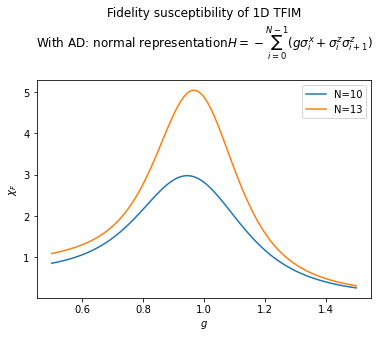

In [18]:
N = 10
N_2 = 13
k = 300
g_count = 100
gs = np.linspace(0.5, 1.5, num = g_count)
fid_sus_from_matrix_AD = np.empty(g_count)
fid_sus_from_matrix_AD_2 = np.empty(g_count)

for i in range(g_count):
    fid_sus_from_matrix_AD[i] = fid_sus_matrix_AD(gs[i], N, k)
    fid_sus_from_matrix_AD_2[i] = fid_sus_matrix_AD(gs[i], N_2, k)
    print(f"\r g={gs[i]}",end="", flush=True)

print("\r Completed.",end="", flush=True)
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(gs, fid_sus_from_matrix_AD, label = "N=10")
ax.plot(gs, fid_sus_from_matrix_AD_2, label = "N=13")
ax.set_xlabel(r"$g$")
ax.set_ylabel(r"$\chi_F$")
ax.set_title("Fidelity susceptibility of 1D TFIM\n" 
             "With AD: normal representation"
        r"$H = - \sum_{i=0}^{N-1} (g\sigma_i^x + \sigma_i^z \sigma_{i+1}^z)$" "\n")
ax.legend()
plt.show()